In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from utils import \
    create_matern32_kernel, \
    create_squared_exp_kernel, \
    real_variable, \
    positive_variable, \
    log_det_from_chol, \
    init_triangular, \
    vec_to_tri

from utils import mu_sigma_tilde, EulerMaruyama, kl_divergence

# Set up the model

In [3]:
tf.reset_default_graph()
np.random.seed(1)
tf.set_random_seed(1)
t_pi = tf.constant(np.pi, dtype=tf.float64) # to make dtype = tf.float64

Parameters of the monotonic flow model:
- `M` is the number of inducing points for the flow GP (`g(s, t)` in the paper),
- `T` is the total simulation time,
- `N_time_steps` is the number of steps in the numerical SDE solver. The step size `dt` is `T / N_time_steps`
- `S` is the number of sampled trajectories used to estimate the expectation in the ELBO

In [4]:
M = 20
T = 1
N_time_steps = 20
dt = T / N_time_steps
S = 5
jitter = 1e-6

## Define the necessary variables

Define placeholders for 1D inputs (`t_X`), the observations (`t_Y`):

In [5]:
t_X = tf.placeholder(shape=(None, 1), dtype=tf.float64)
t_Y = tf.placeholder(shape=(None, 1), dtype=tf.float64)

t_D = tf.shape(t_X)[0] # Number of inputs to be determined at runtime

Define a variable for inverse variance of the observational noise (it is estimated from the data):

In [6]:
t_beta = positive_variable(1.0)

Define the kernel of the flow GP as well as the variables for its hyper-parameters (to be optimised) by maximising the ELBO:

In [7]:
t_alpha = positive_variable(1.0)
t_gamma = positive_variable(1.0)
t_kernel = create_squared_exp_kernel(t_alpha, t_gamma)

Define variables for the inducing locations (in space and time for the flow GP):

In [8]:
# Inducing locations in space initialised between -1 and 1
Z_init_space = np.random.uniform(-1, 1, M).reshape(-1, 1)
t_Z_space = real_variable(Z_init_space)

# Inducing locations in time are constrained to be between 0 and T
# by applying the sigmoid function on the corresponding variable
Z_init_time = np.random.uniform(-3, 3, M).reshape(-1, 1)
t_Z_time = T * tf.nn.sigmoid(real_variable(Z_init_time))

# Concatenate space and time inducing locations into a single tensor
t_Z = tf.concat([t_Z_space, t_Z_time], axis=1)

Define variables for the parameters of the variational distribution of the inducing points. The variational distribution is $U \sim \mathcal{N}(\mathbf{m}, \mathbf{S})$. We define variable `t_m` for the mean, and `t_Sigma` for the covariance, which is parametrised by its Cholesky factor.

In [9]:
t_m = real_variable(1e-1 * np.random.randn(M, 1))

t_L = vec_to_tri(real_variable(1e-3 * init_triangular(M)), M) # Cholesky factor
t_Sigma = tf.matmul(t_L, t_L, transpose_b=True)

## Sample outputs of the monotonic flow

Using the inputs `t_X` and the flow GP defined by its kernel and the inducing points, we want to sample the outputs of the monotonic flow (i.e. the SDE solutions at time `T` with the initial values `t_X`).

First, we define a function computing the parameters of the flow GP posterior distribution at a given spatio-temporal point (equation (2) in the paper): 

In [10]:
def f(t_space_input, t_time_input):
    return mu_sigma_tilde(t_space_input, t_time_input, t_Z, t_m, t_Sigma, t_kernel)

Next, use this function in the SDE solver (the implementation is based on the one provided in https://github.com/hegdepashupati/differential-dgp). The main difference of the monotonic flow construction to the one of Hegde et al. (2019) is the computation of the increments in the numerical solver. We argue that the numerical solver should assume the same Wiener realisation for all trajectories in the vector field (every trajectory corresponds to a certain input) to guarantee monotonicity of the resulting trajectories. This computation is performed in the `_step_func` function of the solver, and we comment on it in the code (see it in `utils.py`).

An alternative is to jointly sample the increments from the flow GP posterior distribution at the current state, which also results in monotonic trajectories. This option can be used by providing a ` jointly_gaussian=True` to the `EulerMaruyama` constructor.

In [11]:
sde_solver = EulerMaruyama(f, T, int(T / dt) + 1) # jointly_gaussian=True

Finally, we use the SDE solver to sample `S` outputs of the monotonic flow:

In [12]:
paths = []
for s in range(S):
    t_path, _ = sde_solver.forward(t_X, save_intermediate=False)
    paths.append(t_path)

t_paths = tf.stack(paths)

## Estimate the ELBO

We use the sampled trajectories of the monotonic flow to estimate the ELBO (equation (4) in the paper). First, we estimate the expectation of the conditional likelihood:

In [13]:
t_first_term = -(t_D / 2) * tf.log(2 * t_pi / t_beta) \
               -(t_beta / 2) * tf.reduce_sum((t_paths - t_Y)**2, axis=(1,2))
t_first_term = tf.reduce_mean(t_first_term)

The second component of the ELBO is the KL divergence of the variational distribution of the inducing points to the prior (assume to be a standard Gaussian):

In [14]:
t_K_ZZ = t_kernel.covar_matrix(t_Z, t_Z)
t_L_Z = tf.cholesky(t_K_ZZ + jitter * tf.diag(tf.ones(M, dtype=tf.float64)))

t_second_term = kl_divergence(t_L_Z, t_m, t_Sigma)

Combine the two terms into the ELBO:

In [15]:
t_lower_bound = t_first_term - t_second_term
t_neg_lower_bound = -tf.reduce_sum(t_lower_bound)

# Run on toy data

Generate simple monotonic data:

In [16]:
D = 50

xs = np.linspace(-1, 1, D).reshape(-1, 1)

ys_noiseless = 1 / (1 + np.exp(-5 * xs)) - 0.5
ys = ys_noiseless + np.random.randn(*xs.shape) * 0.05

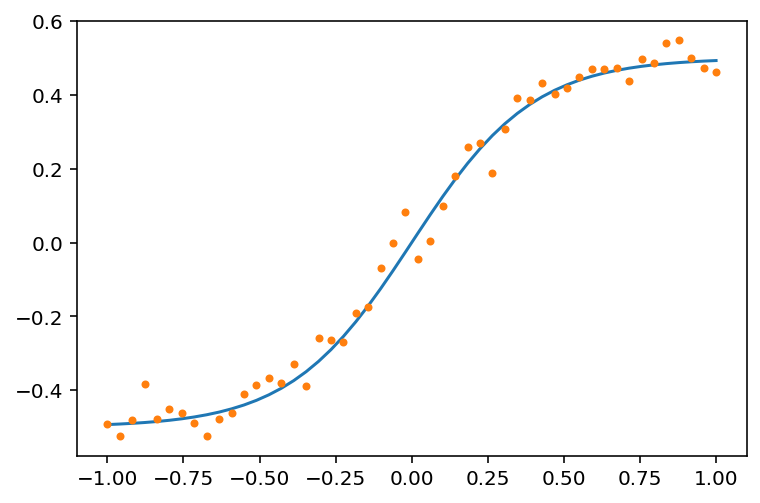

In [17]:
plt.plot(xs.ravel(), ys_noiseless.ravel())
plt.plot(xs.ravel(), ys.ravel(), '.')

Set up the optmiser and intialise the variables:

In [18]:
t_lr = tf.placeholder(dtype=tf.float64)
optimiser = tf.train.AdamOptimizer(learning_rate=t_lr).minimize(t_neg_lower_bound)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
saver = tf.train.Saver()

Run the optimisation decreasing the learning rate:

In [21]:
n_steps = 2000
lr = 1e-2
best_loss = np.inf

feed_dict = {t_Y: ys, t_X: xs, t_lr: lr}

for step in range(n_steps + 1):
    _, loss = sess.run([optimiser, t_neg_lower_bound], feed_dict)
    
    if step % 100 == 0:
        print('iter {:5}: {:10.3f}, {:.2e}'.format(step, loss, np.sqrt(1 / sess.run(t_beta))))
        if loss < best_loss:
            best_loss = loss
            saver.save(sess, 'checkpoints/monotonic_model')

iter     0:  16859.309, 9.95e-01
iter   100:     25.382, 6.02e-01
iter   200:     -6.268, 3.88e-01
iter   300:    -23.567, 2.67e-01
iter   400:    -30.666, 2.05e-01
iter   500:    -44.933, 1.66e-01
iter   600:    -49.843, 1.54e-01
iter   700:    -59.514, 1.36e-01
iter   800:    -27.559, 1.24e-01
iter   900:    -66.066, 1.08e-01
iter  1000:    352.042, 2.16e-01
iter  1100:    736.615, 2.45e-01
iter  1200:     89.252, 2.61e-01
iter  1300:    107.950, 2.77e-01
iter  1400:     50.587, 2.87e-01
iter  1500:     46.878, 2.97e-01
iter  1600:     51.567, 3.04e-01
iter  1700:     46.323, 3.10e-01
iter  1800:    107.381, 3.15e-01
iter  1900:     41.565, 3.22e-01
iter  2000:     31.538, 3.27e-01


In [22]:
# Load the best model
saver.restore(sess, 'checkpoints/monotonic_model')

INFO:tensorflow:Restoring parameters from checkpoints/monotonic_model


## Visualise fitted model

We sampled the monotonic trajectoriries from the fitted model corresponding to the inputs in `[-1,1]` and `[-3,3]`:

In [23]:
pred_input1 = np.linspace(-1, 1, 100).reshape(-1, 1)
pred_input3 = np.linspace(-3, 3, 100).reshape(-1, 1)

In [24]:
paths1 = []
full_paths1 = []

for s in range(25):
    t_path, t_full_path = sde_solver.forward(
        tf.constant(pred_input1, dtype=tf.float64),
        save_intermediate=True)
    paths1.append(t_path)
    full_paths1.append(t_full_path)

t_pred_paths1 = tf.stack(paths1)
t_pred_full_paths1 = tf.stack(full_paths1)

pred_paths1 = sess.run(t_pred_paths1)

In [25]:
paths3 = []
full_paths3 = []

for s in range(25):
    t_path, t_full_path = sde_solver.forward(
        tf.constant(pred_input3, dtype=tf.float64),
        save_intermediate=True)
    paths3.append(t_path)
    full_paths3.append(t_full_path)

t_pred_paths3 = tf.stack(paths3)
t_pred_full_paths3 = tf.stack(full_paths3)

pred_paths3 = sess.run(t_pred_paths3)

In [26]:
pred_mean1, pred_var1 = np.mean(pred_paths1, axis=0)[:,0], np.var(pred_paths1, axis=0)[:,0] + 1 / sess.run(t_beta)
pred_mean3, pred_var3 = np.mean(pred_paths3, axis=0)[:,0], np.var(pred_paths3, axis=0)[:,0] + 1 / sess.run(t_beta)

Plot the sampled trajectories:

Text(0.5, 1.0, 'Predictions, T = 1')

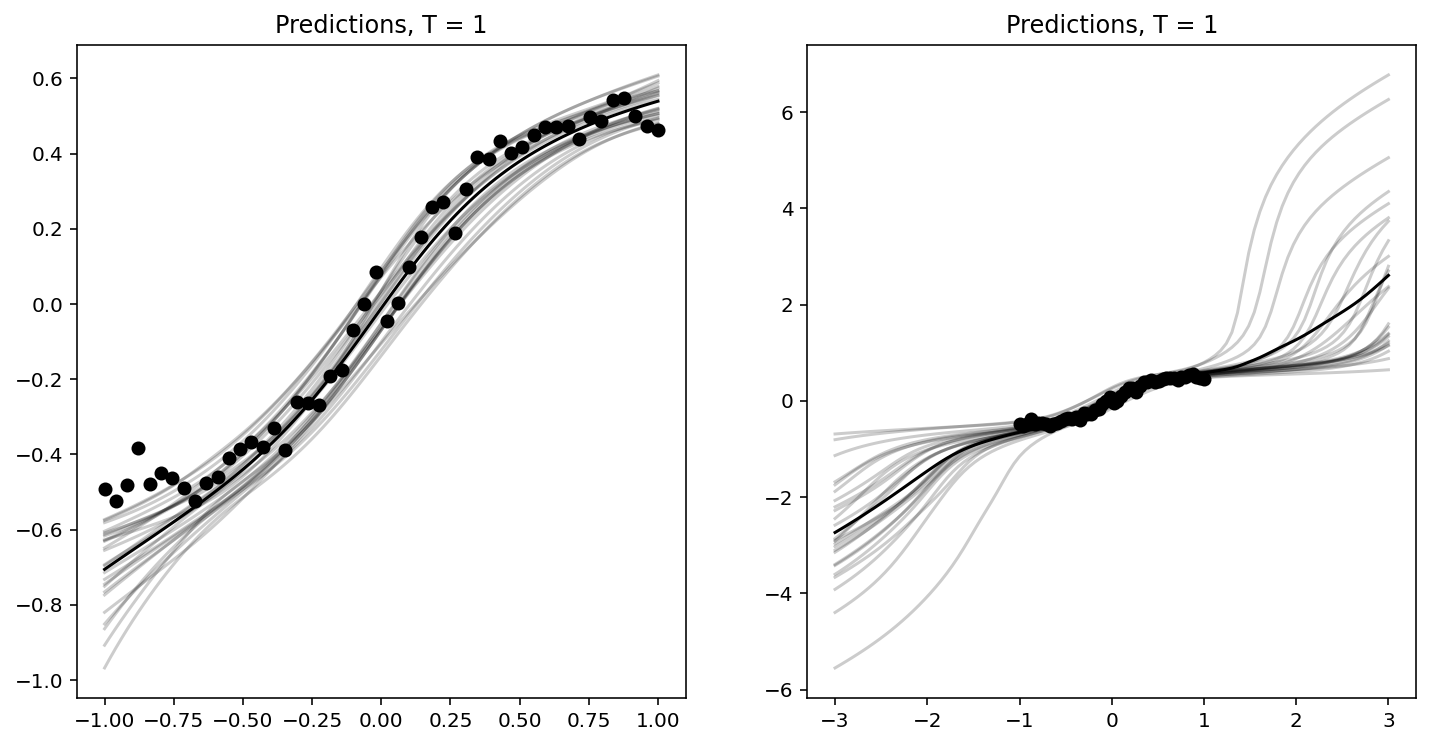

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(xs, ys, 'ko')
plt.plot(pred_input1, pred_mean1, 'k')

for s in range(25):
    plt.plot(pred_input1, pred_paths1[s], 'k', alpha=0.2)
    
plt.title('Predictions, T = {}'.format(T))

plt.subplot(1,2,2)
plt.plot(xs, ys, 'ko')
plt.plot(pred_input3, pred_mean3, 'k')

for s in range(25):
    plt.plot(pred_input3, pred_paths3[s], 'k', alpha=0.2)

plt.title('Predictions, T = {}'.format(T))

Plot the streamlines visualising the flow GP mapping the inputs as well as the inducing points of the flow GP (Figure 2 in the paper):

In [28]:
fp1 = sess.run(t_pred_full_paths1)[:,:,:,0]
fp3 = sess.run(t_pred_full_paths3)[:,:,:,0]

times = np.linspace(0, T, fp1.shape[1])

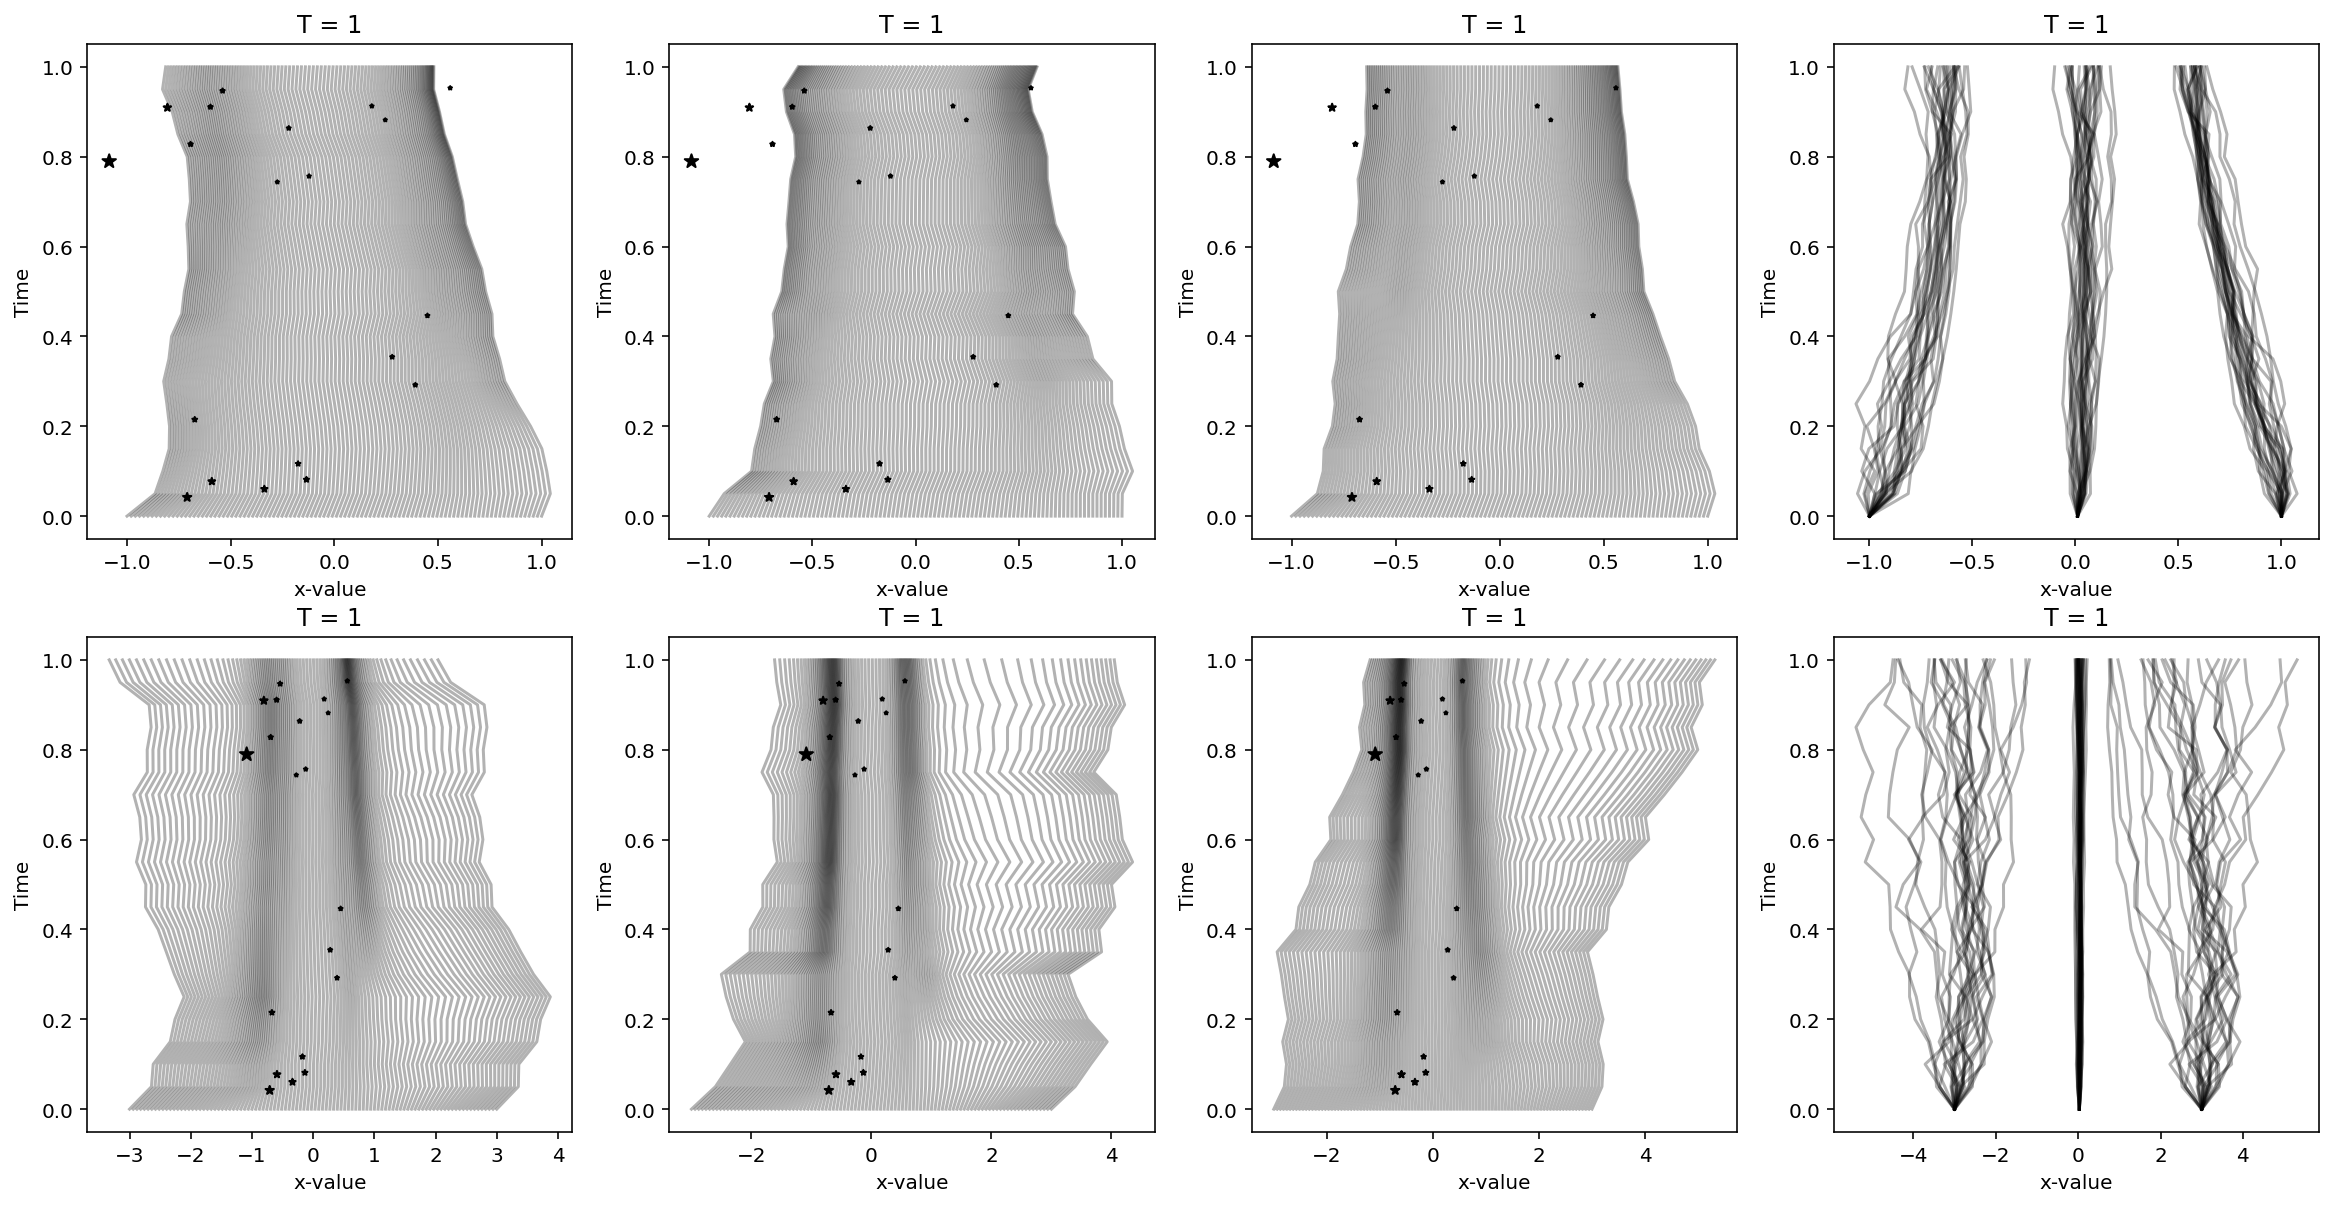

In [29]:
sigmas = sess.run(tf.diag_part(t_Sigma)).ravel()
sizes = 3 * sigmas / sigmas.min()
sizes = np.clip(sizes, 1, 500)

plt.figure(figsize=(20, 10))

for p in range(4):
    plt.subplot(2, 4, p + 1)
    
    if (p + 1) % 4 > 0:
        for i in range(pred_input1.shape[0]):
            plt.plot(fp1[p,:,i], times, 'k', alpha=0.3)
        plt.scatter(sess.run(t_Z)[:,0], sess.run(t_Z)[:,1], color='k', edgecolor='k', marker='*', s=sizes)
    else:
        for p in range(fp1.shape[0]):
            plt.plot(fp1[p,:,0], times, 'k', alpha=0.3)
            plt.plot(fp1[p,:,50], times, 'k', alpha=0.3)
            plt.plot(fp1[p,:,-1], times, 'k', alpha=0.3)

    plt.xlabel('x-value')
    plt.ylabel('Time')
    plt.title('T = {}'.format(T))
    
for p in range(4, 8):
    plt.subplot(2, 4, p + 1)
    
    if (p + 1) % 4 > 0:
        for i in range(pred_input3.shape[0]):
            plt.plot(fp3[p,:,i], times, 'k', alpha=0.3)
        plt.scatter(sess.run(t_Z)[:,0], sess.run(t_Z)[:,1], color='k', edgecolor='k', marker='*', s=sizes)
    else:
        for p in range(fp1.shape[0]):
            plt.plot(fp3[p,:,0], times, 'k', alpha=0.3)
            plt.plot(fp3[p,:,50], times, 'k', alpha=0.3)
            plt.plot(fp3[p,:,-1], times, 'k', alpha=0.3)

    plt.xlabel('x-value')
    plt.ylabel('Time')
    plt.title('T = {}'.format(T))